In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
class PositionalEmbedding1D(nn.Module):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, seq_len, dim):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, dim))
    
    def forward(self, x):
        """Input has shape `(batch_size, seq_len, emb_dim)`"""
        # (1, 3, 14, 14) + (1, 3, 196) ? wtf
        # ohhh flatten before embedding kek
        return x + self.pos_embedding

In [3]:
class MLP(nn.Module):
    def __init__(self, dim, ff_dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, dim)
        
    def forward(self, x):
        out = self.fc2(F.gelu(self.fc1(x)))
        return out

In [4]:
class MHSA(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.q_project = nn.Linear(dim, dim)
        self.q_project = nn.Linear(dim, dim)
        self.q_project = nn.Linear(dim, dim)
        self.out_project = nn.Linear(dim, dim)
        
    def forward(self, x): # input shape [b, s, d]
        # split into q, k, v : (query, key, values)
        # expand by h (num heads... hence multi attention)
        
        q, k, v = self.project(x), self.project(x), self.project(x)
        # convert q, k, v -> [b, h, s, w] where h = n_heads
        q = q.view(q.shape[0], self.n_heads, q.shape[1], -1)
        k = k.view(k.shape[0], self.n_heads, k.shape[1], -1)
        v = v.view(v.shape[0], self.n_heads, v.shape[1], -1)
        
        # scaled dot product attention on q, k (queries, keys) then matmul with values
        # matmul + scale
        # [b, h, s, w] @ [b, h, w, s] -> [b, h, s, s]
        k = k.transpose(-2, -1) # swap last two dimensions
        p = torch.matmul(q, k)
        p = p / np.sqrt(k.size(-1)) # where s is the dimension of k

        p = F.softmax(p, dim = -1) # softmax across last dimension
        
        out = torch.matmul(p, v) # [b, h, s, s] @ [b, h, s, w] -> [b, h, s, w]
        out = out.view(out.shape[0], out.shape[2], -1) # [b, s, d]
        return out

In [5]:
# dont need linear and dont need dropout i think
# add after if performance is shit

class Block(nn.Module): # inputs are B, S, D
    def __init__(self, dim, n_heads, ff_dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.MHSA = MHSA(dim, n_heads)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.mlp_channels = MLP(dim, ff_dim)
        
    def forward(self, x):
        h = self.MHSA(self.norm1(x))
        x = x + h
        h = self.mlp_channels(self.norm2(x))
        x = x + h
        return x

In [6]:
class Transformer(nn.Module):
    def __init__(self, n_layers, dim, n_heads, ff_dim):
        super().__init__()
        self.blocks = nn.ModuleList([Block(dim, n_heads, ff_dim) for _ in range(n_layers)])
    
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

In [7]:
'''
with image 1, 3, 224, 224  and patch encoding of 16x16 we have
((224 - 16) / 16) + 1 = 14
seq len is 14 * 14 bro im trippin bullets
out = (1, 3, 14, 14)
'''

'\nwith image 1, 3, 224, 224  and patch encoding of 16x16 we have\n((224 - 16) / 16) + 1 = 14\nseq len is 14 * 14 bro im trippin bullets\nout = (1, 3, 14, 14)\n'

In [8]:
class ViT(nn.Module):
    def __init__(self, in_channels, dim, fh, fw, n_layers, n_heads, ff_dim, num_classes):
        super().__init__()
        self.fw = fw
        self.fh = fh
        self.patch_encoding = nn.Conv2d(in_channels, dim, kernel_size=(self.fh, self.fw), stride=(self.fh, self.fw))
        # [B, D, FH, FW]
        
        seq_len = 14 * 14
            
        self.positional_embedding = PositionalEmbedding1D(seq_len, dim) # inputs are seq len, dim
        # [B, D, FH, FW]
        
        # flatten into [B, S, D]
        self.Transformer = Transformer(n_layers, dim, n_heads, ff_dim)
        
        # if this doenst work then do it manually
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.head = nn.Linear(dim, num_classes)
        
        # fine tune layer
        self.finetune = nn.Linear(num_classes, 6)
        
    def forward(self, x):
        x = self.patch_encoding(x)
        x = x.view(x.shape[0], -1, x.shape[1]) # b, s, d
        x = self.positional_embedding(x) 
        x = self.Transformer(x)
        x = self.norm(x)
        x = x[:, -1, :] # b, s, d -> b, d
        x = self.head(x)
        x = self.finetune(x)
        return x

In [9]:
#hyperparameters
fw = fh = 16
dim = 768
ff_dim = 3072
n_heads = 12
n_layers = 12
in_channels = 3
num_classes = 1000


In [10]:
model = ViT(in_channels, dim, fh, fw, n_layers, n_heads, ff_dim, num_classes)

In [11]:
x = torch.load("b16.pth")

In [12]:
from collections import OrderedDict

In [13]:
d = OrderedDict()

In [14]:
for i, j in x.items():
    if i[:7] == "blocks.":
        newkey = "Transformer." + i
        d[newkey] = j
    else:
        d[i] = j

In [15]:
dd = OrderedDict()

In [16]:
for i, j in d.items():
    if i[21:31] != 'mlp_tokens':
        dd[i] = j

In [17]:
ddd = OrderedDict()

In [18]:
for i, j in dd.items():
    if i[22:32] != 'mlp_tokens':
        ddd[i] = j

In [19]:
# fuck the rest of these weights
model.load_state_dict(ddd, strict=False)

_IncompatibleKeys(missing_keys=['patch_encoding.weight', 'patch_encoding.bias', 'positional_embedding.pos_embedding', 'Transformer.blocks.0.MHSA.project.weight', 'Transformer.blocks.0.MHSA.project.bias', 'Transformer.blocks.1.MHSA.project.weight', 'Transformer.blocks.1.MHSA.project.bias', 'Transformer.blocks.2.MHSA.project.weight', 'Transformer.blocks.2.MHSA.project.bias', 'Transformer.blocks.3.MHSA.project.weight', 'Transformer.blocks.3.MHSA.project.bias', 'Transformer.blocks.4.MHSA.project.weight', 'Transformer.blocks.4.MHSA.project.bias', 'Transformer.blocks.5.MHSA.project.weight', 'Transformer.blocks.5.MHSA.project.bias', 'Transformer.blocks.6.MHSA.project.weight', 'Transformer.blocks.6.MHSA.project.bias', 'Transformer.blocks.7.MHSA.project.weight', 'Transformer.blocks.7.MHSA.project.bias', 'Transformer.blocks.8.MHSA.project.weight', 'Transformer.blocks.8.MHSA.project.bias', 'Transformer.blocks.9.MHSA.project.weight', 'Transformer.blocks.9.MHSA.project.bias', 'Transformer.blocks.10

# load dataset and train

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import sys
import torchvision
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
import os
import cv2

In [21]:
labels = ['street', 'sea', 'mountain', 'glacier', 'forest', 'buildings']

In [22]:
image_size = (224, 224)

In [23]:
class Data(torch.utils.data.Dataset):
    def __init__(self, labels, image_size):
        self.data = []
        self.labels = []
        self.dir = 'D:/Data/intel/seg_train'
        
        i = 0
        for folder in os.listdir(self.dir):
            label = i
            for file in tqdm(os.listdir(os.path.join(self.dir, folder))):
                img_path = os.path.join(os.path.join(self.dir, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.resize(image, image_size)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = np.reshape(image, [3, 224, 224])
                 
                # Append the image and its corresponding label to the output
                self.data.append(image)
                self.labels.append(label)
            i += 1
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [24]:
import matplotlib.pyplot as plt

In [25]:
test = cv2.imread('D:/Data/intel/seg_train/buildings/0.jpg')

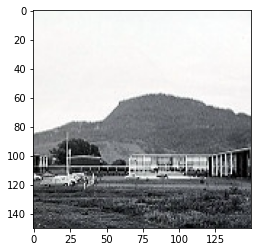

In [26]:
plt.imshow(test)

In [27]:
data = Data(labels, image_size)

100%|████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:01<00:00, 1510.12it/s]


In [28]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

## nn.CrossEntropyLoss doesnt take one hot

In [29]:
# turn labels into one hot
# lol = torch.LongTensor(data.labels)
# one_hot = F.one_hot(lol, 6)
# data.labels = one_hot

In [30]:
# train, val = torch.utils.data.random_split(x, [12630, 1404])
train, val = torch.utils.data.random_split(data, [12630, 1404])

In [31]:
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=16)
valloader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=16)

In [32]:
device = torch.device('cuda')
import torch.optim as optim

In [33]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [34]:
# has softmax in it
loss = nn.CrossEntropyLoss()

In [35]:
model.train()

ViT(
  (patch_encoding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (Transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (MHSA): MHSA(
          (project): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp_channels): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (MHSA): MHSA(
          (project): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp_channels): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=

In [36]:
# this thing is probably gonna overfit but full send i sleep and check reuslts in morning

In [37]:
training_losses = []
val_losses = []
avg_training_losses = []
avg_val_losses = []

In [ ]:
losses = []
for e in tqdm(range(50)):
    for x, y in trainloader:
        torch.cuda.empty_cache()
        x, y = x.to(device), y.to(device)
        x = x.float()
        
        # train step
        optimizer.zero_grad()
        y_pred = model(x)
        l = loss(y_pred, y)
        t_l = l.detach().cpu().numpy()
        l.backward()
        optimizer.step()
        
        training_losses.append(t_l)
        
    for i, j in valloader:
        # no optim zero grad, step, l.backward
        x, y = x.to(device), y.to(device)
        x = x.float()
        
        y_pred = model(x)
        ll = loss(y_pred, y)
        v_l = ll.detach().cpu().numpy()
        
        val_losses.append(v_l)
        
    avg_training_losses.append(np.mean(training_losses))
    avg_val_losses.append(np.mean(val_losses))
        
    print(f' *** Training Loss: {np.mean(training_losses)}, Validation Loss: {np.mean(val_losses)} *** ')

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

In [ ]:
plt.plot(avg_training_losses)
plt.plot(avg_val_losses)

In [ ]:
np.argmax(y_pred, axis=1)

In [ ]:
y

In [ ]:
model.eval()

In [ ]:
a, b = [], []

for x, y in valloader:
    x, y = x.to(device), y.to(device)
    x = x.float()
    y_pred = model(x)
    y_pred, y = y_pred.detach().cpu().numpy(), y.detach().cpu().numpy()
    yes = np.argmax(y_pred, axis=1)
    a.append(yes)
    b.append(y)

In [ ]:
len(trainloader)

In [ ]:
len(valloader)

In [ ]:
count = 0
for i, j in zip(a, b):
    for k, l in zip(i, j):
        if k == l:
            count += 1

In [ ]:
# it overfit
count/1408

* yo thats pretty insane for 10 epochs of training wtf
* i used a bare minimum cnn architecture and it got 50% accuracy a while ago on this dataset and it trained on 90% 10% and this one trained on 50 50 lmao
* this is also highly unoptimized i just did the bare minimum to try to get it to work
* its pretty dope how it could learn hella fast from having 1000 num classes parameters tho

## to do:
#### figure out a cleaner way to load state dict from pretrained weights
#### figure out how to fine tune like a non idiot
### clean up all code and refactor into clean structure

In [ ]:
# [0, 3, 3, 0, 1, 1, 0, 2, 3, 3, 2, 0, 5, 4, 1, 0]
# [0, 3, 3, 1, 0, 1, 5, 2, 2, 2, 3, 0, 1, 4, 1, 0]

In [ ]:
a

In [ ]:
b